<a href="https://colab.research.google.com/github/MiguelAguilera/Neuro-MaxEnt-inference-tutorial/blob/main/3.Oscillating_spike_trains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In some cases, we are not interested in the stationary distribution generating some data, but in the statistical properties of its transient dynamics. Similar to the Maximum Entropy principle is the Maximum Caliber principle (MaxCal), which applies the idea of maximum entropy models to trajectories or paths.

$$ S_{0:t} =- \sum_{\mathbf x_{0:t}} p(\mathbf x_{0:t}) \log p(\mathbf x_{0:t}).$$

with $\mathbf x_{0:t} =\{\mathbf x_0, \mathbf x_1, \ldots, \mathbf x_t\}$.

Generally, if we are interested in causal models, we add a temporal consitencty requirement (Kolmogoroff, 2013), imposing that
$$ \sum_{\mathbf x_{t+1}} p^{(t+1)}(\mathbf x_{0:t+1})= p^{(t)}(\mathbf x_{0:t}).$$

That is, knowledge of the future should not affect our models of the past.

This yields a dynamical rule for describing trajectories. For example, in the case of assuming Markovian (i.e. memoryless) processes, we have that 

$$ p(\mathbf x_{0:t} ) \propto  p(\mathbf x_{0}) \prod_{u=1}^t \exp\left(\sum_n \lambda_n f_n(\mathbf x_{u},\mathbf x_{u-1}) \right). $$

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Define model
class Ising:
    def __init__(self, netsize):    #Create ising model
    
        self.size=netsize
        self.H=np.zeros(netsize)
        self.J=np.zeros((netsize,netsize))
        self.randomize_state()
        self.beta=1.0
    
    def randomize_state(self):
        self.s = np.random.randint(0,2,self.size)*2-1

    def SequentialMetropolisStep(self):
        for i in np.random.permutation(self.size):
            self.MetropolisStep(i)

        
    def GlauberStep(self,i=None):            # Execute step of the Glauber algorithm
        if i is None:
            i = np.random.randint(self.size)
        h = self.H[i] + np.dot(self.J[i,:],self.s)
        self.s[i] = int(np.random.rand()*2-1 < np.tanh(self.beta*h))*2-1   # Glauber

    def SequentialGlauberStep(self):        # Execute N steps of the Glauber algorithm
        for i in np.random.permutation(self.size):
            self.GlauberStep(i)

  
    def SequentialGlauberStepT0(self,i=None):            # Sequential Glauber step at zero temperature
        for i in np.random.permutation(self.size):
          h = self.H[i] + np.dot(self.J[i,:],self.s)
          self.s[i] = np.sign(h) 


### Generating reference data distribution

We generate a sample of spiking neuron data using a network with a random configuration. We store the relevant statistics in `m_data ` and  `Cov_data `.


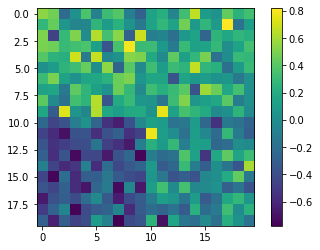

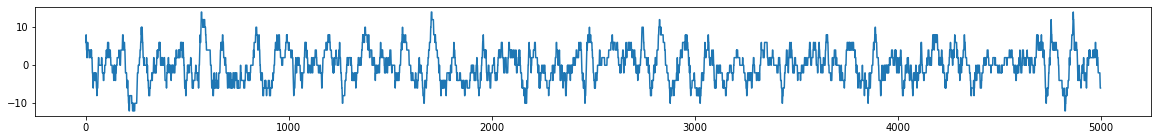

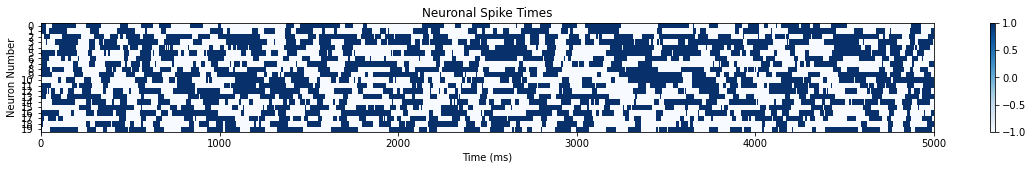

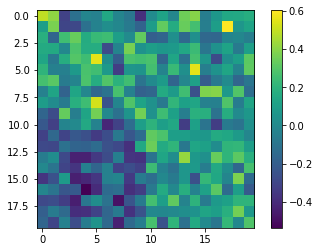

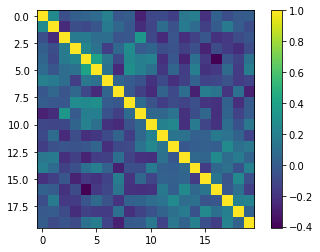

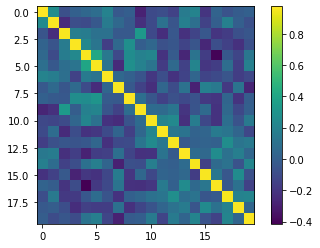

In [2]:
N=20
T=5000

I_data = Ising(N)
I_data.H = 0.05*np.random.randn(N)
I_data.J = np.random.randn(N,N)/np.sqrt(N)
I_data.J[0:N//2,0:N//2] += 4/N
I_data.J[0:N//2,N//2:] += 4/N
I_data.J[N//2:,0:N//2,] += -8/N

plt.figure()
plt.imshow(I_data.J)
plt.colorbar()

Data_sample = np.zeros((N,T))

m_data=np.zeros(N)

C_data=np.zeros((N,N))
D_data=np.zeros((N,N))

I_data.randomize_state()
I_data.s = np.ones(N)
for t in range(T):
  I_data.SequentialGlauberStep()
for t in range(T):
  sp = I_data.s.copy()
  I_data.GlauberStep()
  Data_sample[:,t] = I_data.s
  m_data += I_data.s/T
  D_data  += np.einsum('i,j->ij',I_data.s/T, sp)
  C_data += np.einsum('i,j->ij',sp/T, sp)


fig, ax = plt.subplots(figsize=(20,2))
plt.plot(np.sum(Data_sample,axis=0))


fig, ax = plt.subplots(figsize=(20,2))
plt.imshow(Data_sample, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()

ax.set_xlim([0, T])
ax.set_xlabel('Time (ms)')
# specify tick marks and label label y axis
ax.set_yticks(range(N))
ax.set_ylabel('Neuron Number')
ax.set_title('Neuronal Spike Times') 

plt.figure()
plt.imshow(D_data*N - (N-1)*C_data)
plt.colorbar()

plt.figure()
plt.imshow(C_data)
plt.colorbar()


plt.figure()
plt.imshow(D_data)
plt.colorbar()

## Learning our model

Given the statistics from the data generated by the reference model, we will implement our learning rule to infer the parameters of a new model.

A simple way to display the progress of learning is measuring the mean squared error between the covariances of the original and inferred models.

Text(0.5, 0, 'epoch')

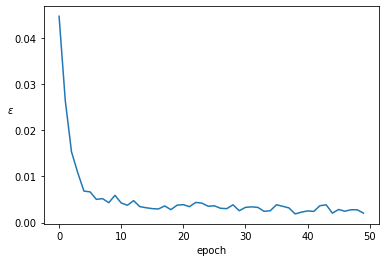

In [3]:
I = Ising(N)
I.H = np.zeros(N)
I.J = np.zeros((N,N))

R=50
eta=0.2

error = np.zeros(R)




for rep in range(R):

  Model_sample = np.zeros((N,T))
  m=np.zeros(N)
  C=np.zeros((N,N))
  D=np.zeros((N,N))
  I.s = Data_sample[:,0]

  dm = np.zeros(N)
  dJ = np.zeros((N,N))
  for t in range(T):
    h = I.H + np.dot(I.J,I.s)
    sp = I.s.copy()
    I.GlauberStep()
    dm += (I.s*N - sp*(N-1) - np.tanh(h))/T
    dJ += (D_data*N - (N-1)*C_data)/T - np.einsum('i,j->ij',(np.tanh(h))/T, sp)
    Model_sample[:,t] = I.s
    m += I.s/T
    D += np.einsum('i,j->ij',I.s/T, sp)
    C += np.einsum('i,j->ij',sp/T, sp)
    
  m = np.mean(Model_sample,axis=1)
  Cov  = np.cov(Model_sample)

  I.H += eta*dm
  I.J += eta*dJ

  error[rep] = np.mean(dJ**2)
  #error[rep] = np.mean((m_data-m)**2)

plt.figure()
plt.plot(error)
plt.ylabel(r'$\epsilon$',rotation=0)
plt.xlabel(r'epoch')


### Comparison of the original and inferred model

Here we show data, statistics and parameters of the original and inferred models

Text(0, 0.5, '$m(t)$')

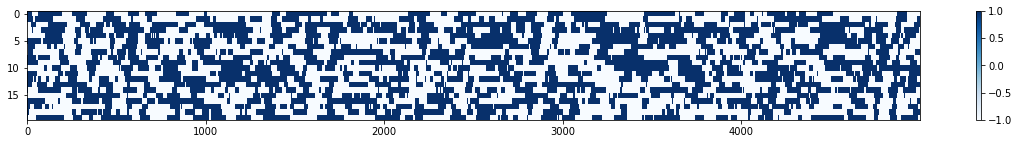

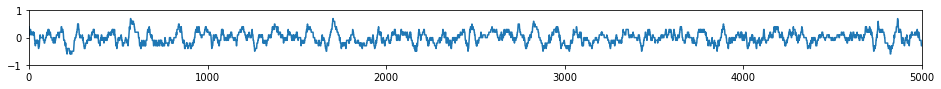

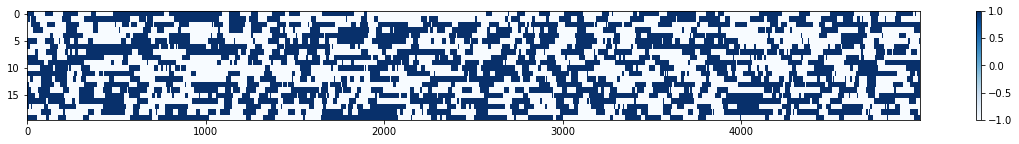

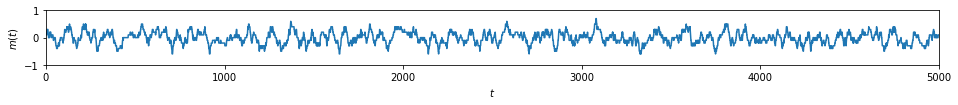

In [4]:

plt.figure(figsize=(20,2))
plt.imshow(Data_sample, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()
plt.figure(figsize=(16,1))
plt.plot(np.mean(Data_sample, axis=0))
plt.axis([0,T,np.min(Data_sample),np.max(Data_sample)])

plt.figure(figsize=(20,2))
plt.imshow(Model_sample, aspect='auto', interpolation='none',cmap='Blues')
plt.colorbar()
plt.figure(figsize=(16,1))
plt.plot(np.mean(Model_sample, axis=0))
plt.axis([0,T,np.min(Model_sample),np.max(Model_sample)])
plt.xlabel(r'$t$')
plt.ylabel(r'$m(t)$')

Covariance matrices

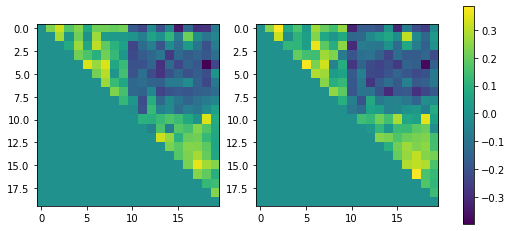

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(np.triu(C_data,1),cmap='viridis',vmin=min(np.min(np.triu(C_data,1)),np.min(np.triu(C,1))), vmax=max(np.max(np.triu(C_data,1)),np.max(np.triu(C,1))))
im = ax[1].imshow(np.triu(C,1), cmap='viridis',vmin=min(np.min(np.triu(C_data,1)),np.min(np.triu(C,1))), vmax=max(np.max(np.triu(C_data,1)),np.max(np.triu(C,1))))
fig.colorbar(im, ax=ax.ravel().tolist())

Coupling matrices

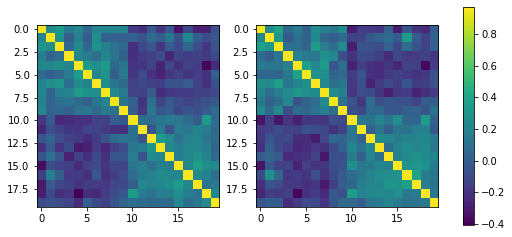

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(D_data,cmap='viridis',vmin=min(np.min(D),np.min(D_data)),vmax=max(np.max(D),np.max(D_data)))
im = ax[1].imshow(D, cmap='viridis',vmin=min(np.min(D),np.min(D_data)),vmax=max(np.max(D),np.max(D_data)))
fig.colorbar(im, ax=ax.ravel().tolist())

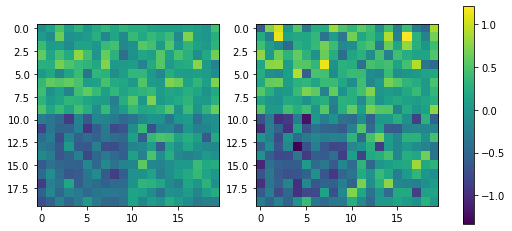

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(9,4))
im = ax[0].imshow(I_data.J,cmap='viridis',vmin=min(np.min(I.J),np.min(I_data.J)),vmax=max(np.max(I.J),np.max(I_data.J)))
im = ax[1].imshow(I.J, cmap='viridis',vmin=min(np.min(I.J),np.min(I_data.J)),vmax=max(np.max(I.J),np.max(I_data.J)))
fig.colorbar(im, ax=ax.ravel().tolist())